In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as sps

from LinearRegression import linear_regression_loss, linear_regression_gradient
from LogisticRegression import logistic_regression_loss, logistic_regression_gradient

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from functools import partial

In [2]:
import importlib
import methods
importlib.reload(methods)
from methods import MinibatchSGD, AsynchronousGD, RennalaSGD, WorkerState

In [3]:
def initialize_methods(w, data, time_distributions, loss_function, gradient_function, n_workers, batch_sizes, lr, compression, compression_rate=None):
    methods = {}
    for method_name, method_class in [('Minibatch SGD', MinibatchSGD), ('Async GD', AsynchronousGD), ('Rennala SGD', RennalaSGD)]:
        if compression_rate is not None:
            methods[method_name] = method_class(w, data, time_distributions, loss_function,
                                                [partial(gradient_function, batch_size=batch_sizes[i]) for i in range(n_workers)],
                                                learning_rate=lr,
                                                compression_flag=compression, compression_size=compression_rate)
        else:
            methods[method_name] = method_class(w, data, time_distributions, loss_function,
                                                [partial(gradient_function, batch_size=batch_sizes[i]) for i in range(n_workers)],
                                                learning_rate=lr,
                                                compression_flag=compression)
        if method_name == 'Rennala SGD':
            methods[method_name].set_batch_size(5)
    return methods

In [4]:
def run_optimization_steps(method, w, n_iterations):
    current_x, loss_history, computation_times, x_history = method.run_steps(n_iterations)
    return loss_history, computation_times

In [5]:
from IPython.display import clear_output
import numpy as np
from functools import partial

def run_optimization_methods(w, data, time_distributions, loss_function,
                             gradient_function, n_workers, batch_sizes, compressions,
                             range_of_k, n_iterations, lr):
    times = dict()
    losses = dict()
    i = 0
    np.random.seed(42)

    for compression in compressions:
        if compression == 'none':
            methods = initialize_methods(w, data, time_distributions, loss_function, gradient_function, n_workers, batch_sizes, lr, compression)
            for method_name, method in methods.items():
                if method_name not in times:
                    times[method_name] = dict()
                if method_name not in losses:
                    losses[method_name] = dict()
                if compression not in times[method_name]:
                    times[method_name][compression] = dict()
                if compression not in losses[method_name]:
                    losses[method_name][compression] = dict()

                w = np.zeros(w.shape[0])
                i += 1
                print(f"Running {method_name} with no compression")
                loss_history, computation_times = run_optimization_steps(method, w, n_iterations)
                times[method_name][compression] = computation_times
                losses[method_name][compression] = loss_history

                # Clear output every 5 iterations
                if i % 5 == 0:
                    clear_output(wait=True)
                    print(f"Cleared output after {i} iterations")
                    i = 0
        else:
            for compression_rate in range_of_k:
                methods = initialize_methods(w, data, time_distributions, loss_function, gradient_function, n_workers, batch_sizes, lr, compression, compression_rate)
                for method_name, method in methods.items():
                    if method_name not in times:
                        times[method_name] = dict()
                    if method_name not in losses:
                        losses[method_name] = dict()
                    if compression not in times[method_name]:
                        times[method_name][compression] = dict()
                    if compression not in losses[method_name]:
                        losses[method_name][compression] = dict()

                    w = np.zeros(w.shape[0])
                    i += 1
                    print(f"Running {method_name} with compression {compression} and compression rate {compression_rate}")
                    loss_history, computation_times = run_optimization_steps(method, w, n_iterations)
                    times[method_name][compression][compression_rate] = computation_times
                    losses[method_name][compression][compression_rate] = loss_history

                    # Clear output every 5 iterations
                    if i % 5 == 0:
                        clear_output(wait=True)
                        print(f"Cleared output after {i} iterations")
                        i = 0

    return times, losses, methods

In [6]:
from sklearn.datasets import make_regression
import numpy as np

X, y = make_regression(
    n_samples=300,
    n_features=100,
    n_informative=90,
    noise=3,
    random_state=42
)

X = np.hstack((X, np.ones((len(X), 1))))

In [7]:
n_workers = 4
time_distributions = [sps.norm(i+1, scale=1) for i in range(n_workers)]
batch_sizes = np.arange(1, n_workers + 1) * 10
n_iterations = 2_000
lr = 1e-3

In [8]:
range_of_k = np.array(np.array([.01, .05, .1, .2]) * X.shape[1], dtype='int')
compressions = ['none', 
                'randk',
                'topk',
                ]
range_of_k

array([ 1,  5, 10, 20])

## Linear regression

In [9]:
w = np.zeros(X.shape[1])
times_lin_regression, losses_lin_regression, methods = run_optimization_methods(w, (X, y), time_distributions,\
                                         linear_regression_loss, linear_regression_gradient,\
                                         n_workers, batch_sizes, compressions, range_of_k,\
                                         n_iterations, lr)

Cleared output after 5 iterations
Running Async GD with compression topk and compression rate 20
Running Rennala SGD with compression topk and compression rate 20


In [10]:
normalization_factors = {}
for method_name in methods:
    normalization_factors[method_name] = {}
    for compression in compressions:
        normalization_factors[method_name][compression] = {}
        if compression == 'none':
            if compression in losses_lin_regression[method_name]:
                normalization_factors[method_name][compression] = np.min(losses_lin_regression[method_name][compression])
        else:
            for compression_rate in range_of_k:
                if compression in losses_lin_regression[method_name] and compression_rate in losses_lin_regression[method_name][compression]:
                    normalization_factors[method_name][compression][compression_rate] = np.min(losses_lin_regression[method_name][compression][compression_rate])

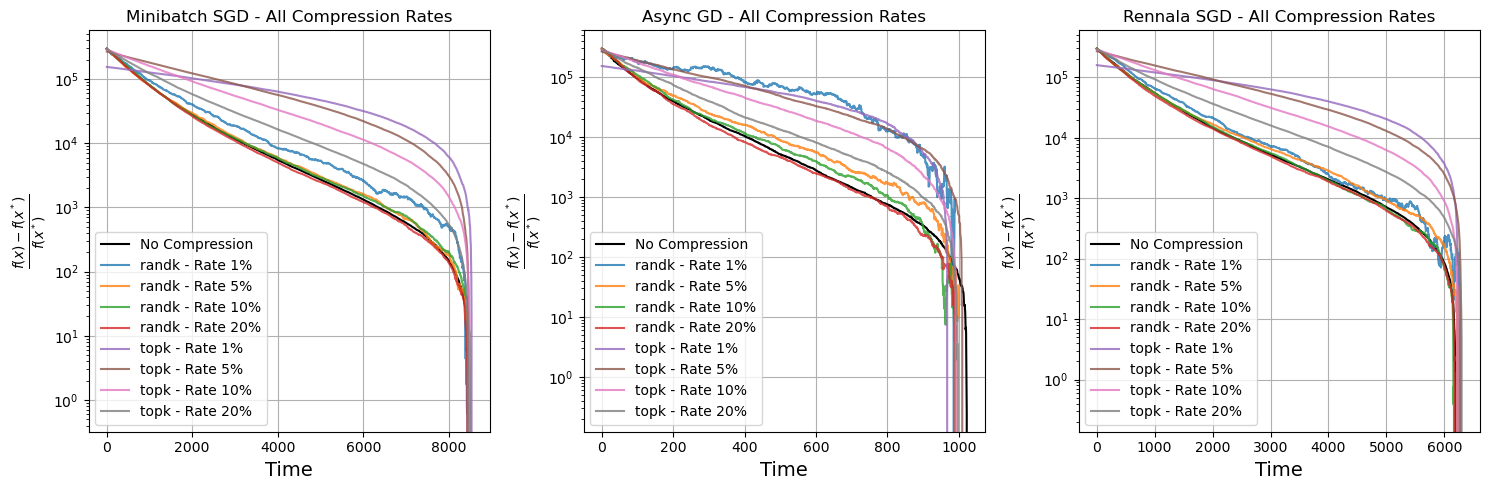

In [11]:
plt.figure(figsize=(15, 5))

compression_percentage = [1, 5, 10, 20]

for method_idx, method_name in enumerate(methods):
    plt.subplot(1, len(methods), method_idx + 1)
    for compression in compressions:
        if compression == 'none':
            if compression in times_lin_regression[method_name]:
                normalized_loss = losses_lin_regression[method_name][compression] - normalization_factors[method_name][compression]
                plt.plot(times_lin_regression[method_name][compression],
                         normalized_loss,
                         label=f'No Compression',
                         color = 'black')
        else:
            i = 0
            for compression_rate in range_of_k:
                if compression in times_lin_regression[method_name] and compression_rate in times_lin_regression[method_name][compression]:
                    normalized_loss = losses_lin_regression[method_name][compression][compression_rate] - normalization_factors[method_name][compression][compression_rate]
                    plt.plot(times_lin_regression[method_name][compression][compression_rate],
                             normalized_loss,
                             label=f'{compression} - Rate {compression_percentage[i]}%',
                             alpha=.8)
                i += 1
    plt.title(f'{method_name} - All Compression Rates')
    plt.xlabel('Time', fontsize=14)
    plt.ylabel(r'$\frac{f(x) - f(x^*)}{f(x^*)}$', fontsize=14)
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## Logistic regression


In [17]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=2000,
    n_features=100,
    n_informative=80,
    n_classes=2,
    random_state=42
)

In [18]:
n_iterations = 2000
lr = 1e-3
range_of_k = np.array(np.array([.01, .05, .1, .2]) * X.shape[1], dtype='int')
compressions = ['none', 
                'randk',
                'topk',
                ]
range_of_k

array([ 1,  5, 10, 20])

In [19]:
w = np.zeros(X.shape[1])
times_log_regression, losses_log_regression, methods = run_optimization_methods(w, (X, y), time_distributions,\
                                         logistic_regression_loss, logistic_regression_gradient,\
                                         n_workers, batch_sizes, compressions, range_of_k,\
                                         n_iterations, lr)

Cleared output after 5 iterations
Running Async GD with compression topk and compression rate 20
Running Rennala SGD with compression topk and compression rate 20


In [20]:
normalization_factors = {}
for method_name in methods:
    normalization_factors[method_name] = {}
    for compression in compressions:
        normalization_factors[method_name][compression] = {}
        if compression == 'none':
            if compression in losses_log_regression[method_name]:
                normalization_factors[method_name][compression] = np.min(losses_log_regression[method_name][compression])
        else:
            for compression_rate in range_of_k:
                if compression in losses_log_regression[method_name] and compression_rate in losses_log_regression[method_name][compression]:
                    normalization_factors[method_name][compression][compression_rate] = np.min(losses_log_regression[method_name][compression][compression_rate])

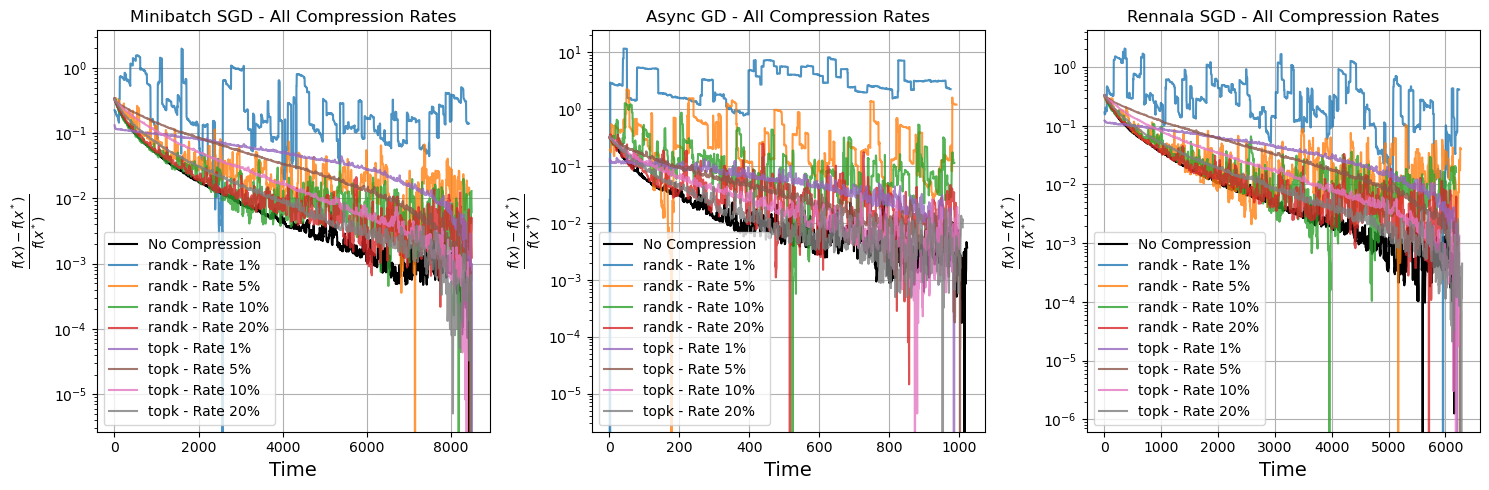

In [21]:
plt.figure(figsize=(15, 5))

compression_percentage = [1, 5, 10, 20]

for method_idx, method_name in enumerate(methods):
    plt.subplot(1, len(methods), method_idx + 1)
    for compression in compressions:
        if compression == 'none':
            if compression in times_log_regression[method_name]:
                normalized_loss = losses_log_regression[method_name][compression] - normalization_factors[method_name][compression]
                plt.plot(times_log_regression[method_name][compression],
                         normalized_loss,
                         label=f'No Compression',
                         color = 'black')
        else:
            i = 0
            for compression_rate in range_of_k:
                if compression in times_log_regression[method_name] and compression_rate in times_log_regression[method_name][compression]:
                    normalized_loss = losses_log_regression[method_name][compression][compression_rate] - normalization_factors[method_name][compression][compression_rate]
                    plt.plot(times_log_regression[method_name][compression][compression_rate],
                             normalized_loss,
                             label=f'{compression} - Rate {compression_percentage[i]}%',
                             alpha=.8)
                i += 1
    plt.title(f'{method_name} - All Compression Rates')
    plt.xlabel('Time', fontsize=14)
    plt.ylabel(r'$\frac{f(x) - f(x^*)}{f(x^*)}$', fontsize=14)
    plt.yscale('log')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()